In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Email network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
from lib.generators.OLP import OLP


generator = OLP(
    network_name='Malaria_var_DBLa_HVR_networks_HVR_networks_9', 
    seed=seed
)

feature_names = generator.feature_names

Loading file...
Network info:

title: Malaria var DBLa HVR networks
description: Networks of recombinant antigen genes from the human malaria parasite P. falciparum. Each of the 9 networks shares the same set of vertices but has different edges, corresponding to the 9 highly variable regions (HVRs) in the DBLa domain of the var protein. Nodes are var genes, and two genes are connected if they share a substring whose length is statistically significant. Metadata includes two types of node labels, both based on sequence structure around HVR6.
networkDomain: Biological
subDomain: Genetic
citation: D. B. Larremore, A. Clauset, and C. O. Buckee, "A network approach to analyzing highly recombinant malaria parasite genes." PLOS Computational Biology 9(10), e1003268 (2013).
sourceUrl: http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003268

File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [80]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [81]:
link_prediction_train.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,21,114,0,0.039216,0.000000,0.002167,0.005219,0.152091,0.024390,0.603197,0.072917,-5.169476e-16,3.921569e-02,2.816901e-02
1,152,251,0,0.000000,0.333333,0.000000,0.000114,0.033229,0.000000,0.000000,0.000000,-8.326673e-17,8.576885e-15,-7.216450e-16
2,42,247,0,0.000000,0.333333,0.000000,0.001539,0.061828,0.000000,0.000000,0.000000,-7.216450e-16,8.793721e-15,3.576671e-16
3,26,192,0,0.000000,0.333333,0.000000,0.001255,0.061994,0.000000,0.000000,0.000000,8.743006e-16,8.694944e-15,1.080187e-16
4,195,295,0,0.039216,0.000000,0.008621,0.000990,0.037857,0.057143,0.577040,0.062741,-3.590878e-16,3.921569e-02,2.500000e-01


## Step 2
### Link prediction model

In [82]:
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_test.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,15,274,0,0.000000,0.333333,0.000000,0.000761,0.031906,0.000000,0.000000,0.000000,3.261280e-16,8.558947e-15,2.131232e-17,0.046491
1,143,231,0,0.156863,0.000000,0.003568,0.002436,0.370144,0.089888,1.892935,0.117642,-2.901325e-15,1.568627e-01,2.105263e-01,0.156478
2,162,265,0,0.039216,0.000000,0.003252,0.001237,0.101174,0.037037,0.696799,0.115385,1.415534e-15,3.921569e-02,1.333333e-01,0.197855
3,127,242,0,0.176471,0.000000,0.006303,0.002147,0.235576,0.128571,2.134102,0.132846,2.151057e-16,1.764706e-01,3.214286e-01,0.261296
4,40,229,0,0.058824,0.000000,0.008571,0.002309,0.057365,0.083333,0.781077,0.064777,-6.678685e-16,5.882353e-02,1.200000e-01,0.168682


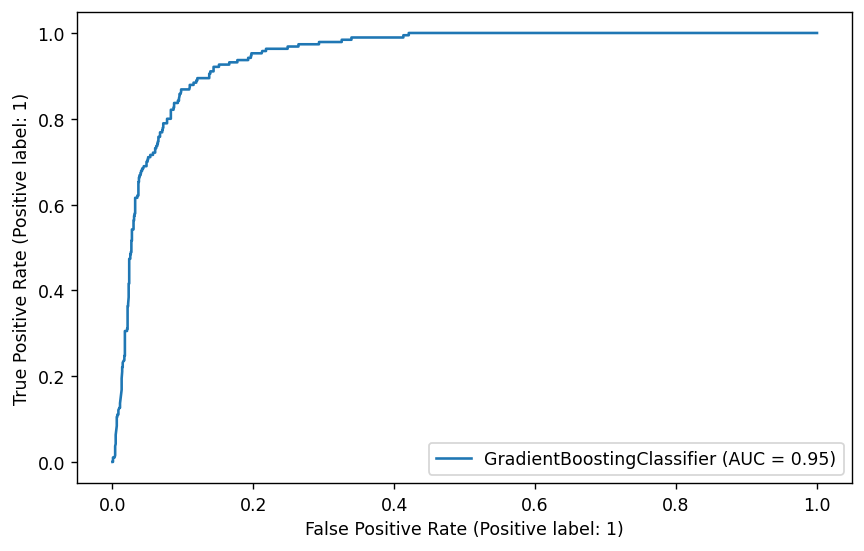

In [83]:
# ROC-AUC for the link prediction model
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model, link_prediction_test[feature_names], link_prediction_test['goal'])  

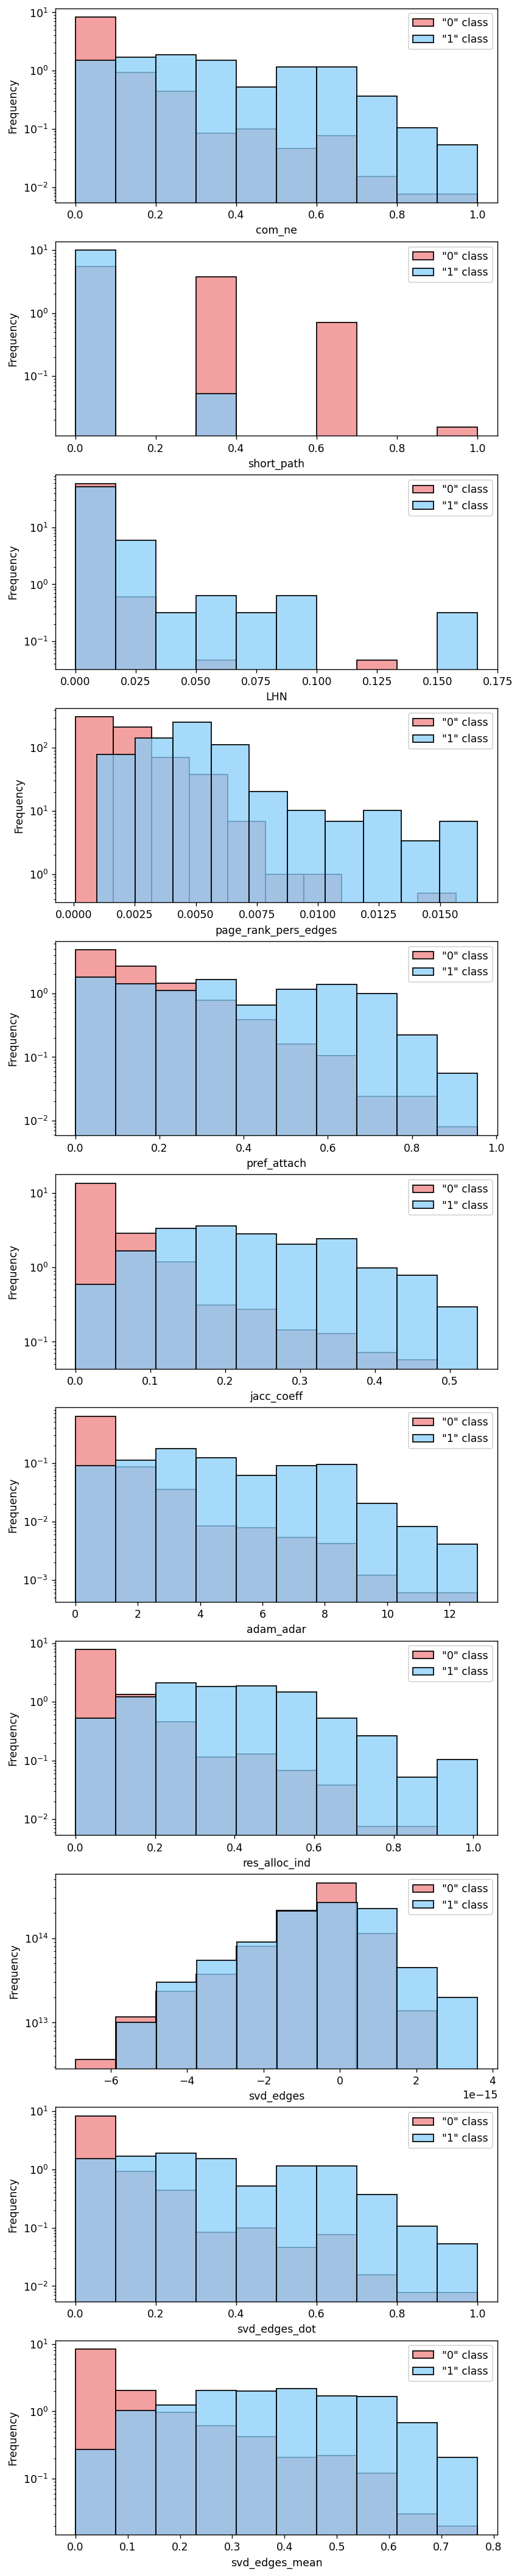

In [84]:
# distribution of features of exesting and non-existing edges

mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))
colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    width = (link_prediction_test[feature].max()-link_prediction_test[feature].min())/10
    for j in [0, 1]:
        data = link_prediction_test[link_prediction_test['goal'] == j]

        sn.histplot(data, x=feature, ax=axs[i], binwidth=width, color=colors[j], stat='density', label=f'"{j}" class')
        axs[i].set(xlabel=feature, ylabel='Frequency')
        axs[i].set_yscale("log")
        axs[i].legend()


## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [85]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,15,274,0,0.000000,0.333333,0.000000,0.000761,0.031906,0.000000,0.000000,0.000000,3.261280e-16,8.558947e-15,2.131232e-17,0.046491,0.046491
1,143,231,0,0.156863,0.000000,0.003568,0.002436,0.370144,0.089888,1.892935,0.117642,-2.901325e-15,1.568627e-01,2.105263e-01,0.156478,0.156478
2,162,265,0,0.039216,0.000000,0.003252,0.001237,0.101174,0.037037,0.696799,0.115385,1.415534e-15,3.921569e-02,1.333333e-01,0.197855,0.197855
3,127,242,0,0.176471,0.000000,0.006303,0.002147,0.235576,0.128571,2.134102,0.132846,2.151057e-16,1.764706e-01,3.214286e-01,0.261296,0.261296
4,40,229,0,0.058824,0.000000,0.008571,0.002309,0.057365,0.083333,0.781077,0.064777,-6.678685e-16,5.882353e-02,1.200000e-01,0.168682,0.168682


In [86]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.0486846153013593

In [87]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,15,274,0,0.000000,0.333333,0.000000,0.000761,0.031906,0.000000,0.000000,0.000000,3.261280e-16,8.558947e-15,2.131232e-17,0.046491,0.046491,1
1,143,231,0,0.156863,0.000000,0.003568,0.002436,0.370144,0.089888,1.892935,0.117642,-2.901325e-15,1.568627e-01,2.105263e-01,0.156478,0.156478,0
2,162,265,0,0.039216,0.000000,0.003252,0.001237,0.101174,0.037037,0.696799,0.115385,1.415534e-15,3.921569e-02,1.333333e-01,0.197855,0.197855,0
3,127,242,0,0.176471,0.000000,0.006303,0.002147,0.235576,0.128571,2.134102,0.132846,2.151057e-16,1.764706e-01,3.214286e-01,0.261296,0.261296,0
4,40,229,0,0.058824,0.000000,0.008571,0.002309,0.057365,0.083333,0.781077,0.064777,-6.678685e-16,5.882353e-02,1.200000e-01,0.168682,0.168682,0


In [88]:
model_2 = GradientBoostingClassifier(n_estimators=500, max_depth=6, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

GradientBoostingClassifier(max_depth=6, n_estimators=250, random_state=778)

In [89]:
# testing the classifier

pred = model_2.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])[:,1]
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [90]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.04867361876986615

In [91]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,151,213,0,0.078431,0.000000,0.004329,0.001357,0.152257,0.066667,1.025662,0.082462,-2.095546e-15,7.843137e-02,1.818182e-01,0.297471,0,0.297471,0
1,3,224,0,0.000000,0.666667,0.000000,0.000549,0.006447,0.000000,0.000000,0.000000,-8.170548e-16,8.657707e-15,3.512815e-17,0.041979,1,0.041979,1
2,42,127,0,0.039216,0.000000,0.003017,0.004021,0.109109,0.032258,0.540368,0.049390,1.844445e-15,3.921569e-02,3.921569e-02,0.047170,0,0.047170,1
3,29,184,0,0.000000,0.333333,0.000000,0.001782,0.008101,0.000000,0.000000,0.000000,-5.447032e-16,8.608013e-15,-8.750346e-17,0.053865,0,0.053865,0
4,141,198,0,0.000000,0.333333,0.000000,0.000857,0.227641,0.000000,0.000000,0.000000,-2.905879e-15,6.061638e-15,-1.937026e-15,0.017141,1,0.017141,1


In [92]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     759
0                     736
dtype: int64

In [93]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          772
0                          723
dtype: int64

In [94]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    model_2.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1495.000000
1,Accuracy,0.932441
2,Precision,0.932654
3,Recall,0.932441
4,F1 score,0.932427


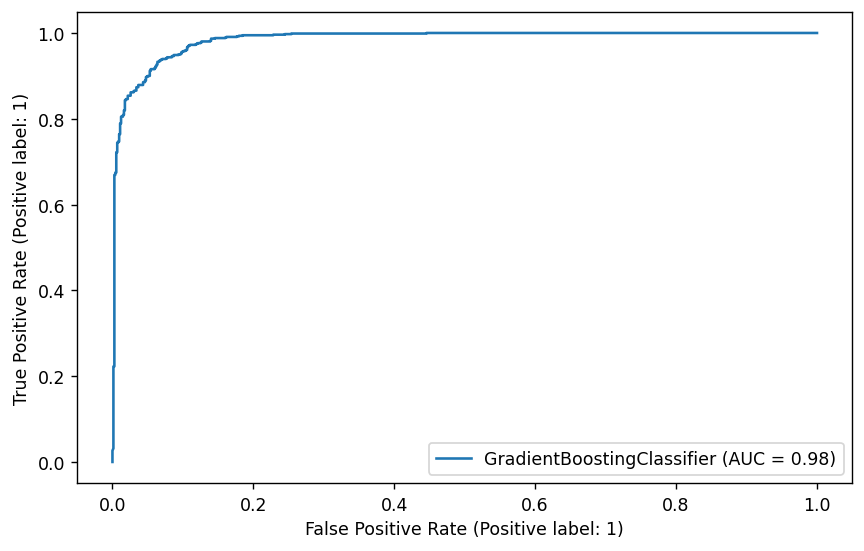

In [95]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])  

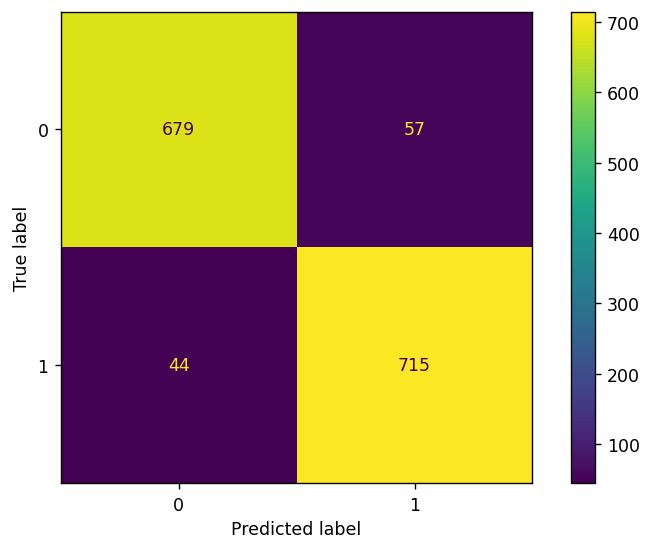

In [96]:
metrics.plot_confusion_matrix(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])

In [97]:
importances_pd = pd.DataFrame()
importances_pd['Reconstruction feature importance'] = pd.Series(model.feature_importances_, index=feature_names)
importances_pd['Classification feature importance'] = pd.Series(model_2.feature_importances_, index=feature_names)
importances_pd['Diff'] = importances_pd.apply(lambda x: math.fabs(x['Reconstruction feature importance'] - x['Classification feature importance']), axis=1)

importances_pd

,Reconstruction feature importance,Classification feature importance,Diff
com_ne,0.002445,0.003617,0.001172
short_path,0.000071,0.034739,0.034669
LHN,0.043248,0.041315,0.001933
page_rank_pers_edges,0.024292,0.150737,0.126446
pref_attach,0.031020,0.125694,0.094674
jacc_coeff,0.037221,0.035124,0.002097
adam_adar,0.017692,0.042968,0.025276
res_alloc_ind,0.796436,0.132725,0.663711
svd_edges,0.000000,0.000000,0.000000
svd_edges_dot,0.001857,0.001932,0.000075


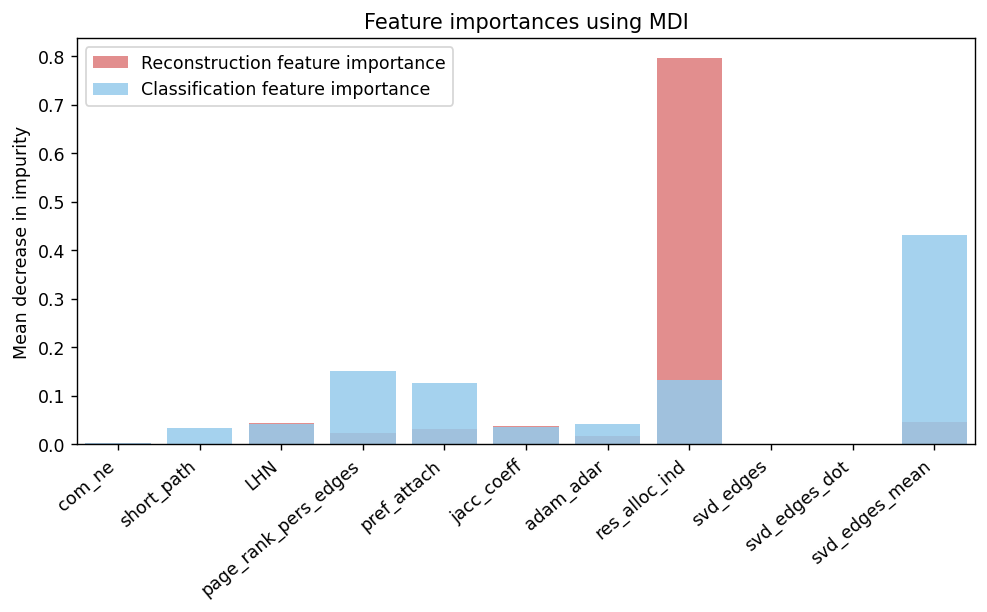

In [98]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

fig, ax = plt.subplots()

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Reconstruction feature importance', 
    label='Reconstruction feature importance',
    ax=ax, 
    color='lightcoral', 
    alpha=1
)

sn.barplot(
    data=importances_pd, 
    x=feature_names, 
    y='Classification feature importance', 
    label='Classification feature importance', 
    ax=ax, 
    color='lightskyblue', 
    alpha=0.85
)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend()

fig.tight_layout()